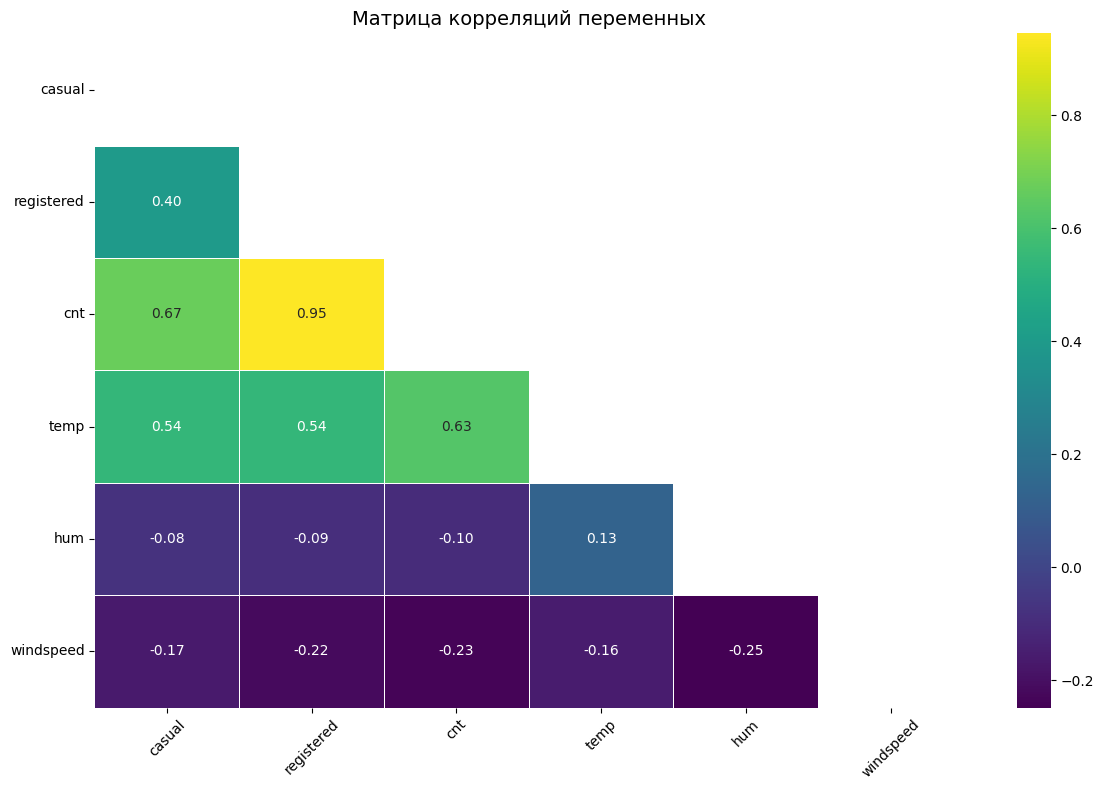

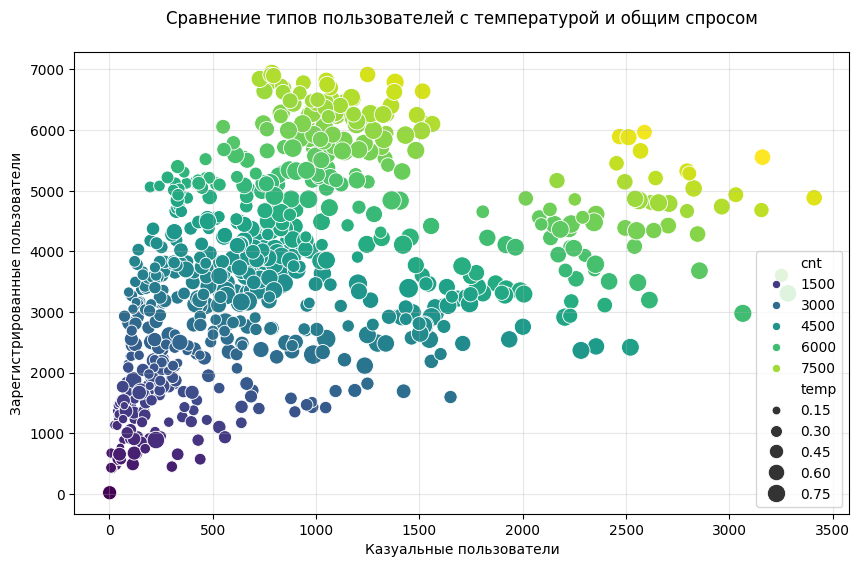

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Загрузка данных с локального файла
day_df = pd.read_csv('day.csv')

# Выбор основных переменных для анализа
target_vars = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']

# Корреляционная матрица
plt.figure(figsize=(12,8))
corr_matrix = day_df[target_vars].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Скроем дублирующиеся значения

sns.heatmap(corr_matrix, 
           mask=mask,
           annot=True, 
           fmt=".2f", 
           cmap='viridis',
           linewidths=0.5)
plt.title('Матрица корреляций переменных', fontsize=14)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
# Pairplot для целевых переменных
plt.figure(figsize=(10,6))
sns.scatterplot(data=day_df, 
                x='casual', 
                y='registered',
                hue='cnt', 
                palette='viridis',
                size='temp',
                sizes=(20, 200))
plt.title("Сравнение типов пользователей с температурой и общим спросом", pad=20)
plt.xlabel("Казуальные пользователи")
plt.ylabel("Зарегистрированные пользователи")
plt.grid(alpha=0.3)
plt.show()

2. Air Quality Dataset (временные ряды)

C:\Users\User\AppData\Local\Temp\ipykernel_6332\181416691.py:19: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_excel(


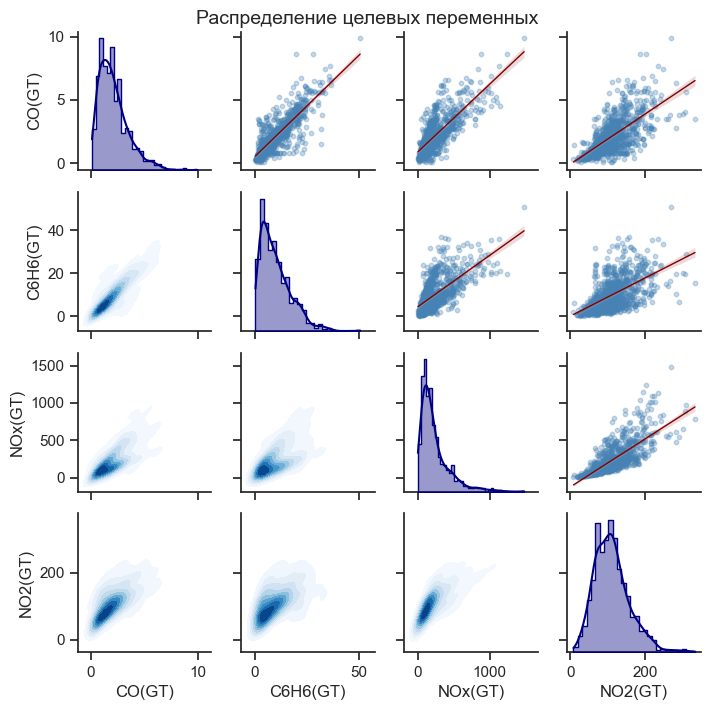

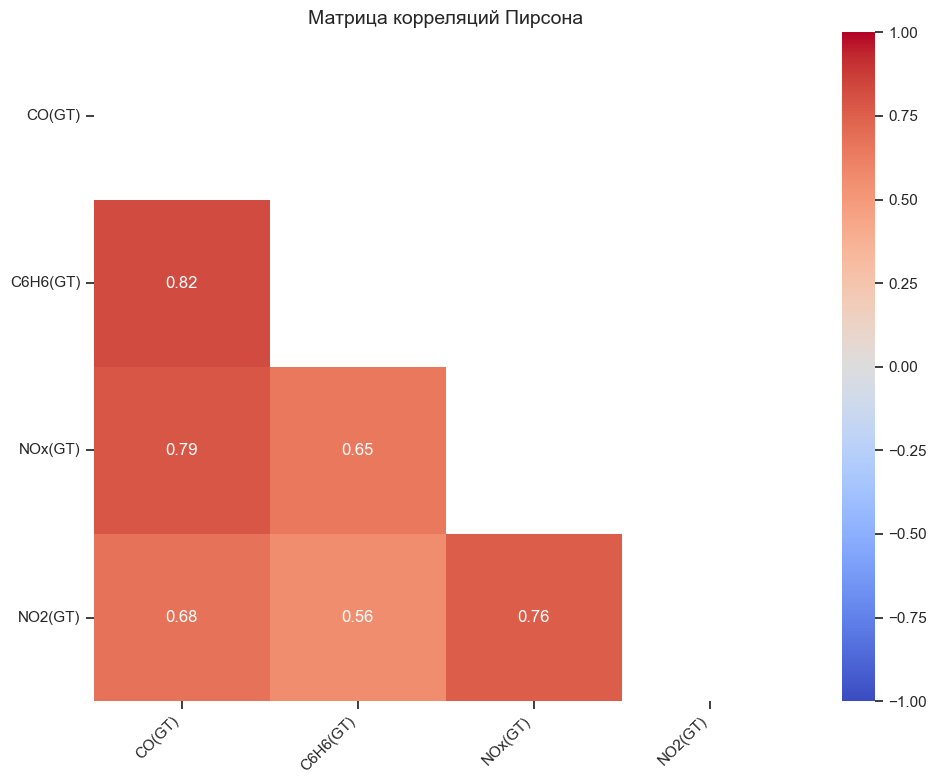

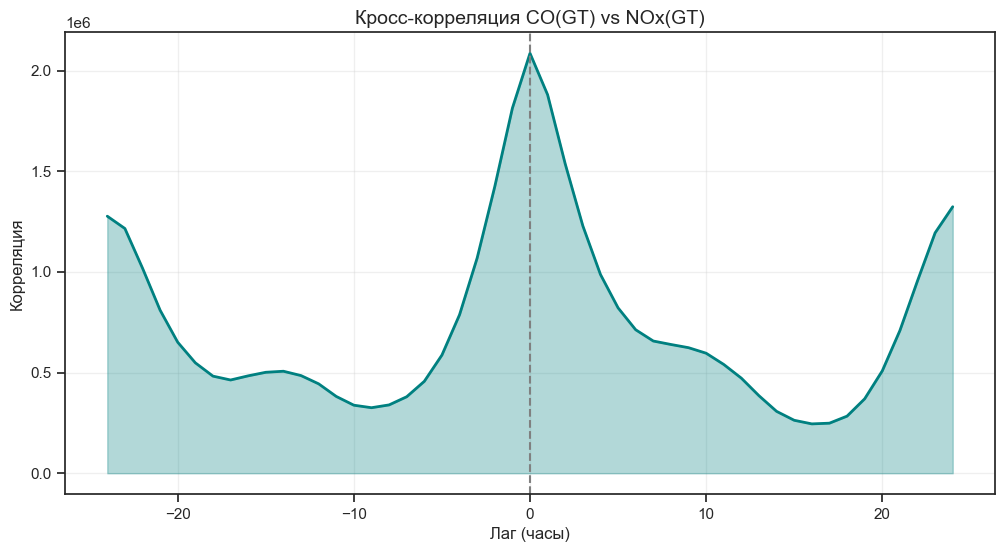

In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
from scipy.signal import correlate

# ===========================================
# 1. ПОЛНЫЙ КОД ПРЕДОБРАБОТКИ ДАННЫХ
# ===========================================

def safe_date_parser(date_col, time_col):
    """Кастомный парсер для колонок Date и Time"""
    datetime_str = date_col.dt.strftime('%d/%m/%Y') + ' ' + time_col.astype(str).str.replace('.',':')
    return pd.to_datetime(datetime_str, format='%d/%m/%Y %H:%M:%S', errors='coerce')

def load_and_preprocess(path):
    # Загрузка данных с коррекцией форматов
    df = pd.read_excel(
        path,
        engine='openpyxl',
        parse_dates={'DateTime': ['Date', 'Time']}, 
        date_parser=lambda x: pd.to_datetime(x, format='mixed', dayfirst=True),
        na_values=['-200', -200]
    )
    
    # Конвертация числовых колонок
    numeric_cols = ['CO(GT)', 'C6H6(GT)', 'T', 'RH', 'AH', 'NOx(GT)', 'NO2(GT)']
    df[numeric_cols] = df[numeric_cols].replace(',','.', regex=True).apply(pd.to_numeric, errors='coerce')
    
    # Интерполяция пропусков
    df = df.set_index('DateTime').interpolate(method='time', limit_direction='both').reset_index()
    return df.dropna()

# ===========================================
# 2. УСТОЙЧИВЫЕ ФУНКЦИИ КОРРЕЛЯЦИЙ
# ===========================================

def safe_correlate(x, y, method):
    """Универсальная функция корреляции с обработкой NaN"""
    mask = ~np.isnan(x) & ~np.isnan(y)
    x_clean = x[mask]
    y_clean = y[mask]
    
    if len(x_clean) < 3:
        return np.nan
    
    try:
        if method == 'pearson':
            return pearsonr(x_clean, y_clean)[0]
        elif method == 'spearman':
            return spearmanr(x_clean, y_clean)[0]
    except:
        return np.nan

def calculate_correlations(df, targets):
    """Расчёт корреляций с автоматическим выбором метода"""
    results = {}
    for method in ['pearson', 'spearman']:
        corr_matrix = pd.DataFrame(
            index=targets,
            columns=targets,
            data=np.nan
        )
        for i, col1 in enumerate(targets):
            for j, col2 in enumerate(targets):
                if i <= j:
                    corr = safe_correlate(df[col1], df[col2], method)
                    corr_matrix.loc[col1, col2] = corr
                    corr_matrix.loc[col2, col1] = corr
        results[method] = corr_matrix.astype(float)
    return results

# ===========================================
# 3. УЛУЧШЕННАЯ ВИЗУАЛИЗАЦИЯ
# ===========================================

def enhanced_pairplot(df, targets, sample_size=1000):
    """Оптимизированный pairplot для больших наборов данных"""
    sample = df[targets].sample(min(sample_size, len(df)))
    
    g = sns.PairGrid(sample, diag_sharey=False, height=1.8)
    g.map_upper(sns.regplot, 
               scatter_kws={'s': 10, 'alpha': 0.3, 'color': 'steelblue'},
               line_kws={'color': 'maroon', 'lw': 1})
    g.map_lower(sns.kdeplot, 
               cmap='Blues', 
               fill=True, 
               levels=10,
               warn_singular=False)
    g.map_diag(sns.histplot, 
              kde=True, 
              element='step', 
              fill=True, 
              alpha=0.4,
              color='navy')
    plt.subplots_adjust(top=0.95)
    g.fig.suptitle('Распределение целевых переменных', fontsize=14)
    return g

def plot_cross_correlation(df, col1, col2, max_lag=72):
    """Визуализация кросс-корреляции с доверительными интервалами"""
    x = df[col1].values - np.nanmean(df[col1])
    y = df[col2].values - np.nanmean(df[col2])
    
    # Расчёт корреляции с нормализацией
    corr = correlate(x, y, mode='full', method='auto') 
    lags = np.arange(-max_lag, max_lag+1)
    corr = corr[len(corr)//2 - max_lag : len(corr)//2 + max_lag + 1]
    
    plt.figure(figsize=(12,6))
    plt.fill_between(lags, corr, alpha=0.3, color='teal')
    plt.plot(lags, corr, color='teal', lw=2)
    plt.axvline(0, color='gray', ls='--')
    plt.title(f'Кросс-корреляция {col1} vs {col2}', fontsize=14)
    plt.xlabel('Лаг (часы)', fontsize=12)
    plt.ylabel('Корреляция', fontsize=12)
    plt.grid(alpha=0.3)
    plt.show()

# ===========================================
# 4. ИСПОЛНЯЕМЫЙ КОД
# ===========================================

if __name__ == "__main__":
    # Загрузка данных
    df = load_and_preprocess('AirQualityUCI.xlsx')
    
    # Целевые переменные
    targets = ['CO(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)']
    
    # Анализ корреляций
    corr_results = calculate_correlations(df, targets)
    pearson_corr = corr_results['pearson']
    spearman_corr = corr_results['spearman']
    
    # Визуализация
    enhanced_pairplot(df, targets)
    
    # Тепловая карта Пирсона
    plt.figure(figsize=(10,8))
    sns.heatmap(pearson_corr, 
               annot=True, 
               fmt=".2f", 
               cmap="coolwarm", 
               vmin=-1, 
               vmax=1,
               mask=np.triu(np.ones_like(pearson_corr, dtype=bool)))
    plt.title('Матрица корреляций Пирсона', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # Анализ кросс-корреляции
    plot_cross_correlation(df, 'CO(GT)', 'NOx(GT)', max_lag=24)
